# Predicting MLB Strikeout Rates from Velocity and Movement

Using data from 2012-2016, we first determine a classification system for different pitches using a clustering algorithm.  Motivation for this work was provided by http://www.sloansportsconference.com/wp-content/uploads/2019/02/Predicting-Major-League-Baseball-Strikeout-Rates-Update.pdf.

These features are then used to construct a model to predict strikeout rates using several regression models.

In [1]:
from pybaseball import statcast, pitching_stats, pitching_stats_range
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/chrisjackson/.venvs/closedloop/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### get the data

The raw data is scraped from statcast and/or pitch fx using the pybaseball module.  We remove "short relievers" by keeping only pitchers that have thrown at least 1000 pitches in a season AND that average 10 batters faced per appearance.

The data columns used from the pitcher data are:

- game_pk: the unique game ID
- inning: inning of the pitch
- game_year: the year of the data
- player_name: the pitcher's name (this is used to join to a separate data pull that is required to extract strikeouts per 9 innings)
- batter: used to keep track of batters faced
- release_speed: speed of the ball at time of release (feature used for pitch categorization in the clustering algorithm)
- pfx_x, pfx_z: movement in the horizontal and vertical directions (features used for pitch categorization in the clustering algorithm)

In [2]:
# lists of NL and AL teams that we use to construct a "league" flag 
NL_TEAMS = ['Braves', 'Brewers', 'Cardinals', 'Cubs', 'Diamondbacks', 'Dodgers', 'Giants',
            'Marlins', 'Mets', 'Nationals', 'Padres', 'Phillies', 'Pirates', 'Reds', 'Rockies']

AL_TEAMS = ['Angels', 'Astros', 'Athletics', 'Blue Jays', 'Indians', 'Mariners', 'Orioles', 
            'Rangers', 'Rays', 'Red Sox', 'Royals', 'Tigers', 'Twins', 'White Sox', 'Yankees']

def team_to_league(x):
    if x in NL_TEAMS:
        return 0
    elif x in AL_TEAMS:
        return 1
    else:
        return 2

def avg_batters_faced(df, pitcher_id):
    
    # subset the given pitcher's games
    temp_df = df[df['pitcher']==pitcher_id]
    
    # count number of batters faced in each game
    temp_df = temp_df.drop_duplicates(subset=['game_pk', 'inning', 'batter'])
    total_batters_faced = len(temp_df)

    # count the number of appearances
    number_of_games = len(temp_df['game_pk'].unique())
    
    # return the average number of batters faced per game
    return round(total_batters_faced / number_of_games, 1)


def get_speed_location_data(start, end):

    # get the raw pitch data from statcast
    pitch_data = statcast(start_dt=start, end_dt=end)
    
    # make sure index columns are int
    pitch_data['game_pk'] = pitch_data['game_pk'].astype(int)
    pitch_data['inning'] = pitch_data['inning'].astype(int)
    pitch_data['game_year'] = pitch_data['game_year'].astype(int)
    pitch_data['pitcher'] = pitch_data['pitcher'].astype(int)
    pitch_data['batter'] = pitch_data['batter'].astype(int)
    
    # get the data for K rate and to compute the pitcher's strike percentage
    strike_data = pitching_stats(start[:4])
    strike_data = strike_data[['Season', 'Name', 'Team', 'SO', 'TBF', 'Pitches', 'Strikes']]
    strike_data.columns = ['game_year', 'player_name', 'team', 'SO', 'TBF', 'Pitches', 'Strikes']
    strike_data['k_rate'] = strike_data['SO'] / strike_data['TBF']
    strike_data['strike_pct'] = strike_data['Strikes'] / strike_data['Pitches']
    strike_data['league'] = strike_data['team'].apply(team_to_league)
    strike_data.drop(['team', 'SO', 'TBF', 'Pitches', 'Strikes'], axis=1, inplace=True)
    strike_data['game_year'] = strike_data['game_year'].astype(int)
    
    # merge the two dataframes together
    pitch_data = pd.merge(pitch_data, strike_data, how='inner', on=['game_year', 'player_name'])
        
    # select the columns that we need
    cols_to_keep = ['game_pk', 'inning', 'game_year', 'player_name', 'league', 'pitcher', 'batter', 'release_speed', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'strike_pct', 'k_rate']
    pitch_data = pitch_data[cols_to_keep]
    
    # drop any rows that have no game_pk
    pitch_data = pitch_data[~pd.isnull(pitch_data['game_pk'])]
    
    # make an index for observations 
    pitch_data['obs_index'] = pitch_data['game_year'].astype(str) + "_" + pitch_data['pitcher'].astype(str)
    
    # get a count of pitchers and number of pitches they threw
    pitcher_count = dict(Counter(pitch_data['pitcher']))

    # list of pitchers with at least 1000 pitches thrown
    pitchers_w_1000pitches = [k for k, v in pitcher_count.items() if v >= 1000]
    
    # subset the dataframe to those pitchers with at least 1000 pitches thrown
    pitch_data = pitch_data[pitch_data['pitcher'].isin(pitchers_w_1000pitches)]
    
    # list of pitchers with at least 1000 pitches thrown AND average number of batters faced per outing greater than 10
    pitchers_no_short = [x for x in pitchers_w_1000pitches if avg_batters_faced(pitch_data, x) >= 10.0]

    # subset the dataframe to those pitchers with at least 1000 pitches thrown
    pitch_data = pitch_data[pitch_data['pitcher'].isin(pitchers_no_short)]
        
    # keep only columns we need
    pitch_data = pitch_data[['obs_index', 'pitcher', 'player_name', 'league', 'release_speed', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'strike_pct', 'k_rate']]
        
    return pitch_data

### get the data using pybaseball

Fill in the start and end dates of the season of interest.

In [3]:
# train_data_dates = [('2012-03-28', '2012-10-03'),
#                     ('2013-03-31', '2013-09-30'),
#                     ('2014-03-22', '2014-09-28'),
#                     ('2015-04-05', '2015-10-04'),
#                     ('2016-04-03', '2016-10-02')]

train_data_dates = [('2016-04-03', '2016-10-02'), ('2017-04-02', '2017-10-01')]

train_data_list = []
for dates in train_data_dates:
    df = get_speed_location_data(start=dates[0], end=dates[1])
    train_data_list.append(df)
    
train_data = pd.concat(train_data_list)
train_data.to_csv("/Users/chrisjackson/sports/baseball/MLBStrikeoutRatePrediction/train.csv", index=False)
print(f"Shape of training data: {train_data.shape}")
print(f"Number of unique pitchers in training data: {len(train_data['pitcher'].unique())}")
print(f"Number of unique observations in training data: {len(train_data['obs_index'].unique())}")

This is a large query, it may take a moment to complete
Completed sub-query from 2016-04-03 to 2016-04-08
Completed sub-query from 2016-04-09 to 2016-04-14
Completed sub-query from 2016-04-15 to 2016-04-20
Completed sub-query from 2016-04-21 to 2016-04-26
Completed sub-query from 2016-04-27 to 2016-05-02
Completed sub-query from 2016-05-03 to 2016-05-08
Completed sub-query from 2016-05-09 to 2016-05-14
Completed sub-query from 2016-05-15 to 2016-05-20
Completed sub-query from 2016-05-21 to 2016-05-26
Completed sub-query from 2016-05-27 to 2016-06-01
Completed sub-query from 2016-06-02 to 2016-06-07
Completed sub-query from 2016-06-08 to 2016-06-13
Completed sub-query from 2016-06-14 to 2016-06-19
Completed sub-query from 2016-06-20 to 2016-06-25
Completed sub-query from 2016-06-26 to 2016-07-01
Completed sub-query from 2016-07-02 to 2016-07-07
Completed sub-query from 2016-07-08 to 2016-07-13
Completed sub-query from 2016-07-14 to 2016-07-19
Completed sub-query from 2016-07-20 to 2016-

In [4]:
test_data_dates = [('2018-03-29', '2018-10-01')]

test_data_list = []
for dates in test_data_dates:
    df = get_speed_location_data(start=dates[0], end=dates[1])
    test_data_list.append(df)
    
test_data = pd.concat(test_data_list)
test_data.to_csv("/Users/chrisjackson/sports/baseball/MLBStrikeoutRatePrediction/test.csv", index=False)
print(f"Shape of test data: {test_data.shape}")
print(f"Number of unique pitchers in test data: {len(test_data['pitcher'].unique())}")
print(f"Number of unique observations in test data: {len(test_data['obs_index'].unique())}")

This is a large query, it may take a moment to complete
Completed sub-query from 2018-03-29 to 2018-04-03
Completed sub-query from 2018-04-04 to 2018-04-09
Completed sub-query from 2018-04-10 to 2018-04-15
Completed sub-query from 2018-04-16 to 2018-04-21
Completed sub-query from 2018-04-22 to 2018-04-27
Completed sub-query from 2018-04-28 to 2018-05-03
Completed sub-query from 2018-05-04 to 2018-05-09
Completed sub-query from 2018-05-10 to 2018-05-15
Completed sub-query from 2018-05-16 to 2018-05-21
Completed sub-query from 2018-05-22 to 2018-05-27
Completed sub-query from 2018-05-28 to 2018-06-02
Completed sub-query from 2018-06-03 to 2018-06-08
Completed sub-query from 2018-06-09 to 2018-06-14
Completed sub-query from 2018-06-15 to 2018-06-20
Completed sub-query from 2018-06-21 to 2018-06-26
Completed sub-query from 2018-06-27 to 2018-07-02
Completed sub-query from 2018-07-03 to 2018-07-08
Completed sub-query from 2018-07-09 to 2018-07-14
Completed sub-query from 2018-07-15 to 2018-

### the pitch type cluster analysis

#### select the features that we use in the clustering 

In [5]:
cluster_train_data = train_data[['plate_x', 'plate_z', 'pfx_x', 'pfx_z', 'release_speed']]
cluster_train_data.dropna(inplace=True)

print(f"Number of pitches in the clustering data: {cluster_train_data.shape[0]}\n")
cluster_train_data.head()

Number of pitches in the clustering data: 829076



,plate_x,plate_z,pfx_x,pfx_z,release_speed
1134,0.005,1.958,-0.519667,-0.790433,83.0
1135,0.425,3.316,0.807983,2.071933,96.0
1136,-0.134,3.893,0.749533,1.971600,94.4
1137,-0.216,3.037,0.839992,1.682067,95.3
1138,-1.166,4.112,0.699433,1.736533,94.8


#### standardize the data: scale the features to be between 0 and 1

In [6]:
plate_x_scaler = MinMaxScaler()
plate_x = cluster_train_data['plate_x'].as_matrix().reshape(-1, 1)
plate_x_scaled = pd.DataFrame(plate_x_scaler.fit_transform(plate_x))

plate_z_scaler = MinMaxScaler()
plate_z = cluster_train_data['plate_z'].as_matrix().reshape(-1, 1)
plate_z_scaled = pd.DataFrame(plate_z_scaler.fit_transform(plate_z))

pfx_x_scaler = MinMaxScaler()
pfx_x = cluster_train_data['pfx_x'].as_matrix().reshape(-1, 1)
pfx_x_scaled = pd.DataFrame(pfx_x_scaler.fit_transform(pfx_x))

pfx_z_scaler = MinMaxScaler()
pfx_z = cluster_train_data['pfx_z'].as_matrix().reshape(-1, 1)
pfx_z_scaled = pd.DataFrame(pfx_z_scaler.fit_transform(pfx_z))

release_speed_scaler = MinMaxScaler()
release_speed = cluster_train_data['release_speed'].as_matrix().reshape(-1, 1)
release_speed_scaled = pd.DataFrame(release_speed_scaler.fit_transform(release_speed))

cluster_train_data_scaled = pd.concat([plate_x_scaled, plate_z_scaled, pfx_x_scaled, pfx_z_scaled, release_speed_scaled], axis=1, join='inner')

cluster_train_data_scaled.columns = ['plate_z', 'plate_z', 'pfx_x', 'pfx_z', 'release_speed']
cluster_train_data_scaled.head()

,plate_z,plate_z,pfx_x,pfx_z,release_speed
0,0.438791,0.448306,0.486088,0.327229,0.685668
1,0.459653,0.533552,0.683805,0.598685,0.897394
2,0.431886,0.569772,0.675101,0.589170,0.871336
3,0.427813,0.516039,0.688572,0.561711,0.885993
4,0.380624,0.583520,0.667640,0.566877,0.877850


#### DBSCAN

#### k-means with Elbow method and Silhouette averages to find optimal k

#### k-means with Gap statistic to find optimal k

In [7]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k, n_jobs=-1)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

k, _ = optimalK(cluster_train_data_scaled)
print(f"The optimal number of clusters is: {k}")

The optimal number of clusters is: 7


In [8]:
# perform k-means clustering (with number of clusters determined from elbow method)
kmeans = KMeans(n_clusters=k, n_jobs=-1).fit(cluster_train_data_scaled)

print(kmeans.score(cluster_train_data_scaled))

-9193.194669570788


### categorize pitches using k-means clusters

In [9]:
def categorize_pitches(df):

    df = df[['obs_index', 'player_name', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z', 'release_speed']]
    
    df.dropna(inplace=True)

    df['plate_x_scaled'] = plate_x_scaler.transform(df['plate_x'].as_matrix().reshape(-1,1))
    df['plate_z_scaled'] = plate_z_scaler.transform(df['plate_z'].as_matrix().reshape(-1,1))
    df['pfx_x_scaled'] = pfx_x_scaler.transform(df['pfx_x'].as_matrix().reshape(-1,1))
    df['pfx_z_scaled'] = pfx_z_scaler.transform(df['pfx_z'].as_matrix().reshape(-1,1))
    df['release_speed_scaled'] = release_speed_scaler.transform(df['release_speed'].as_matrix().reshape(-1,1))

    df = df[['obs_index', 'player_name', 'plate_x_scaled', 'plate_z_scaled', 'pfx_x_scaled', 'pfx_z_scaled', 'release_speed_scaled']]

    df['cluster_number'] = kmeans.predict(df[['plate_x_scaled', 'plate_z_scaled', 'pfx_x_scaled', 'pfx_z_scaled', 'release_speed_scaled']]) 
    
    return df

train_data_categorized = categorize_pitches(train_data)

test_data_categorized = categorize_pitches(test_data)

test_data_categorized.head()

,obs_index,player_name,plate_x_scaled,plate_z_scaled,pfx_x_scaled,pfx_z_scaled,release_speed_scaled,cluster_number
2002,2018_628317,Kenta Maeda,0.424832,0.544004,0.457416,0.521770,0.845277,3
2003,2018_628317,Kenta Maeda,0.413139,0.358026,0.376387,0.430575,0.739414,0
2004,2018_628317,Kenta Maeda,0.494926,0.340644,0.393096,0.466442,0.742671,0
2005,2018_628317,Kenta Maeda,0.426571,0.521142,0.449418,0.538850,0.848534,3
2006,2018_628317,Kenta Maeda,0.424008,0.381309,0.431756,0.477301,0.732899,0


### turn counts of cluster types into features

In [10]:
def convert_counts_to_features(df, thresh):
    
    obs_list = list(df['obs_index'].unique())

    pitch_counts_df = pd.DataFrame(columns=[0,1,2,3,4,5,6])

    for i, obs in enumerate(obs_list):

        temp_df = df[df['obs_index']==obs]

        pitch_df = pd.DataFrame(dict(Counter(temp_df['cluster_number'])), index=[obs])

        pitch_counts_df = pitch_counts_df.append(pitch_df)
        
    # if number of pitches is below thresh, replace count with NaN
    def num_pitches_thresh(x):
        if x < thresh:
            return np.nan
        else:
            return x
    for col in pitch_counts_df.columns.tolist():
        pitch_counts_df[col] = pitch_counts_df[col].apply(num_pitches_thresh)
    return pitch_counts_df

train_pitch_counts_df = convert_counts_to_features(train_data_categorized, thresh=0)

test_pitch_counts_df = convert_counts_to_features(test_data_categorized, thresh=0)

print(train_pitch_counts_df.shape)
print(train_pitch_counts_df.head())

print(test_pitch_counts_df.shape)
print(test_pitch_counts_df.head())

(366, 7)
                 0       1       2      3      4      5       6
2016_519141    7.0  1219.0  1078.0  179.0  316.0   42.0     NaN
2016_592717  149.0     NaN     NaN  292.0    NaN  473.0  2005.0
2016_456034   12.0  2656.0   247.0   89.0  563.0   27.0     NaN
2016_527048   48.0  2305.0   227.0   25.0  466.0    7.0     NaN
2016_518560   54.0     NaN     1.0   21.0    NaN  370.0   750.0
(178, 7)
                 0      1      2       3      4       5      6
2018_628317  300.0    NaN    4.0   758.0  538.0   262.0  103.0
2018_621111   22.0  153.0    NaN   916.0  255.0   342.0  391.0
2018_608566  176.0    NaN    7.0  1317.0  634.0   568.0  415.0
2018_448802    5.0  500.0  279.0   103.0  340.0   153.0    NaN
2018_468504  557.0    NaN    9.0   277.0   73.0  1327.0  763.0


In [11]:
train_pitch_counts_df.head()

,0,1,2,3,4,5,6
2016_519141,7.0,1219.0,1078.0,179.0,316.0,42.0,NaN
2016_592717,149.0,NaN,NaN,292.0,NaN,473.0,2005.0
2016_456034,12.0,2656.0,247.0,89.0,563.0,27.0,NaN
2016_527048,48.0,2305.0,227.0,25.0,466.0,7.0,NaN
2016_518560,54.0,NaN,1.0,21.0,NaN,370.0,750.0


#### count the number of used clusters for each observation

For comparison to the paper.

In [12]:
train_pitch_counts_df['num_clusters'] = 0

for i in range(len(train_pitch_counts_df)):
    
    train_pitch_counts_df['num_clusters'].iloc[i] = pd.notnull(train_pitch_counts_df.iloc[i,0]) + pd.notnull(train_pitch_counts_df.iloc[i,1]) +\
                                                    pd.notnull(train_pitch_counts_df.iloc[i,2]) + pd.notnull(train_pitch_counts_df.iloc[i,3]) +\
                                                    pd.notnull(train_pitch_counts_df.iloc[i,4]) + pd.notnull(train_pitch_counts_df.iloc[i,5]) +\
                                                    pd.notnull(train_pitch_counts_df.iloc[i,6])


train_pitch_counts_df.head()

,0,1,2,3,4,5,6,num_clusters
2016_519141,7.0,1219.0,1078.0,179.0,316.0,42.0,NaN,6
2016_592717,149.0,NaN,NaN,292.0,NaN,473.0,2005.0,4
2016_456034,12.0,2656.0,247.0,89.0,563.0,27.0,NaN,6
2016_527048,48.0,2305.0,227.0,25.0,466.0,7.0,NaN,6
2016_518560,54.0,NaN,1.0,21.0,NaN,370.0,750.0,5


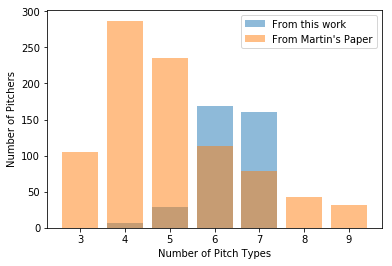

In [19]:
cluster_count = dict(Counter(train_pitch_counts_df['num_clusters']))
plt.bar(list(cluster_count.keys()), list(cluster_count.values()), alpha=0.5, label="From this work")
plt.bar([3, 4, 5, 6, 7, 8 , 9], [105, 287, 235, 114, 79, 42, 32], alpha=0.5, label="From Martin's Paper")
plt.xlabel('Number of Pitch Types')
plt.ylabel('Number of Pitchers')
plt.legend()
plt.show()

### Train the Regression Models

#### First, train a baseline model with just release_speed and strike_pct as features

In [48]:
train_data.head()

,pitcher,player_name,league,release_speed,pfx_x,pfx_z,plate_x,plate_z,strike_pct,k_rate
obs_index,,,,,,,,,,
2016_519141,519141,Drew Pomeranz,2,83.0,-0.519667,-0.790433,0.005,1.958,0.630764,0.26458
2016_519141,519141,Drew Pomeranz,2,96.0,0.807983,2.071933,0.425,3.316,0.630764,0.26458
2016_519141,519141,Drew Pomeranz,2,94.4,0.749533,1.971600,-0.134,3.893,0.630764,0.26458
2016_519141,519141,Drew Pomeranz,2,95.3,0.839992,1.682067,-0.216,3.037,0.630764,0.26458
2016_519141,519141,Drew Pomeranz,2,94.8,0.699433,1.736533,-1.166,4.112,0.630764,0.26458


In [50]:
train_data.reset_index(inplace=True, drop=False)
base_train_data = train_data[['obs_index', 'k_rate', 'release_speed', 'strike_pct']]
base_train_data = pd.DataFrame(base_train_data.groupby(['obs_index', 'k_rate', 'strike_pct'])['release_speed'].mean())
base_train_data.reset_index(inplace=True, drop=False)
base_train_data.drop('obs_index', axis=1, inplace=True)

test_data.reset_index(inplace=True, drop=False)
base_test_data = test_data[['obs_index', 'k_rate', 'release_speed', 'strike_pct']]
base_test_data = pd.DataFrame(base_test_data.groupby(['obs_index', 'k_rate', 'strike_pct'])['release_speed'].mean())
base_test_data.reset_index(inplace=True, drop=False)
base_test_data.drop('obs_index', axis=1, inplace=True)
base_test_data.head()

X_train = base_train_data.drop('k_rate', axis=1)
y_train = base_train_data['k_rate']

X_test = base_test_data.drop('k_rate', axis=1)
y_test = base_test_data['k_rate']

print(f'Mean K rate for training data: {round(base_train_data["k_rate"].mean(), 2)}')
print(f'Mean K rate for testing data: {round(base_test_data["k_rate"].mean(), 2)}')
      
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Mean K rate for training data: 0.2
Mean K rate for testing data: 0.21
Mean Absolute Error: 0.035140020940982335
Adjusted R^2: 0.1483525193391274


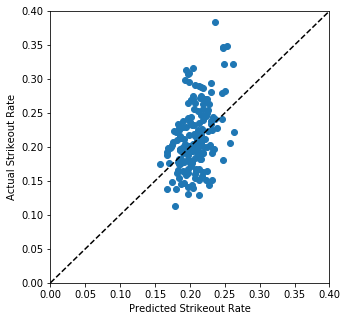

In [52]:
fig = plt.figure(figsize=(5,5))
plt.scatter(y_pred, y_test)
plt.plot([0., 0.4], [0., 0.4], 'k--')
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])
plt.xlabel('Predicted Strikeout Rate')
plt.ylabel('Actual Strikeout Rate')
plt.show()

#### Next, prepare the clustered data by merging the K rate data with pitch counts data

In [60]:
#train_data.set_index('obs_index', inplace=True, drop=True)
strike_train_data = train_data[['k_rate', 'strike_pct', 'league']]

train_data_Kpct = pd.merge(strike_train_data, train_pitch_counts_df, left_index=True, right_index=True)

train_data_Kpct.drop('num_clusters', axis=1, inplace=True)

# fill na's (with 0 or 1 depending on if we are taking the log's of columns)
train_data_Kpct.fillna(value=1.0, inplace=True)

train_data_Kpct.drop_duplicates(inplace=True)

train_data_Kpct.columns = ['k_rate', 'strike_pct', 'league', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6']

# take log of pitch count columns
for col in ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6']:
    train_data_Kpct[col] = np.log(train_data_Kpct[col])

print(f"Shape of the training data: {train_data_Kpct.shape}")
train_data_Kpct.head()

Shape of the training data: (367, 10)


,k_rate,strike_pct,league,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
2016_112526,0.161820,0.682089,0,7.237778,0.000000,2.397895,6.371612,5.093750,2.197225,6.542472
2016_282332,0.197917,0.640206,1,5.743003,7.005789,5.996452,6.021023,6.476972,3.433987,0.000000
2016_285064,0.166667,0.589209,0,5.501258,0.000000,4.204693,6.068426,4.897840,4.997212,5.897154
2016_285079,0.173077,0.645879,1,6.028279,1.098612,7.299121,0.000000,6.023448,6.068426,0.000000
2016_407793,0.240642,0.656151,0,5.068904,0.000000,3.135494,6.872128,6.472346,5.921578,6.530878


In [61]:
#test_data.set_index('obs_index', inplace=True, drop=True)
strike_test_data = test_data[['k_rate', 'strike_pct', 'league']]

test_data_Kpct = pd.merge(strike_test_data, test_pitch_counts_df, left_index=True, right_index=True)
#test_data_Kpct.drop('num_clusters', axis=1, inplace=True)

# fill na's (with 0 or 1 depending on if we are taking the log's of columns)
test_data_Kpct.fillna(value=1.0, inplace=True)

test_data_Kpct.drop_duplicates(inplace=True)

test_data_Kpct.columns = ['k_rate', 'strike_pct', 'league', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6']

# take log of pitch count columns
for col in ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6']:
    test_data_Kpct[col] = np.log(test_data_Kpct[col])

print(f"Shape of the test data: {test_data_Kpct.shape}")
test_data_Kpct.head()

Shape of the test data: (178, 10)


,k_rate,strike_pct,league,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
2018_112526,0.128981,0.661580,1,7.345365,0.000000,2.944439,5.568345,4.990433,4.406719,5.129899
2018_282332,0.210526,0.658955,1,4.727388,5.991465,6.489205,6.405228,6.551080,3.401197,0.000000
2018_425844,0.237187,0.648194,0,6.542472,2.833213,0.000000,6.993015,6.549651,6.369901,4.828314
2018_429719,0.178478,0.606613,1,4.779123,2.564949,0.000000,6.161207,6.359574,4.043051,5.476464
2018_430935,0.233251,0.636720,2,1.609438,7.353082,5.991465,3.555348,6.777647,5.170484,0.000000


#### Split data into training and test Sets

In [62]:
X_train = train_data_Kpct.drop('k_rate', axis=1)
y_train = train_data_Kpct['k_rate']

X_test = test_data_Kpct.drop('k_rate', axis=1)
y_test = test_data_Kpct['k_rate']

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(367, 9)
(367,)
(178, 9)
(178,)


#### Linear Regression

In [63]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Mean Absolute Error: 0.03482096683493352
Adjusted R^2: 0.07967229797833109


#### (Off-the-shelf) Random Forest

In [64]:
rf_reg = RandomForestRegressor()

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Mean Absolute Error: 0.037255411728892296
Adjusted R^2: 0.027173766452150416


#### (Off-the-shelf) AdaBoost 

In [65]:
ab_reg = AdaBoostRegressor()

ab_reg.fit(X_train, y_train)

y_pred = ab_reg.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Mean Absolute Error: 0.03387403038860532
Adjusted R^2: 0.1894986363801744


#### Optimized Random Forest

Using Scikit-Learn's GridSearchCV to find the optimal set of hyperparameters.

In [66]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_d

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.3s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.6s


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samp

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.1min


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   4.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  4.5min finished


{'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
Mean Absolute Error: 0.033352684843667796
Adjusted R^2: 0.2240015184767068


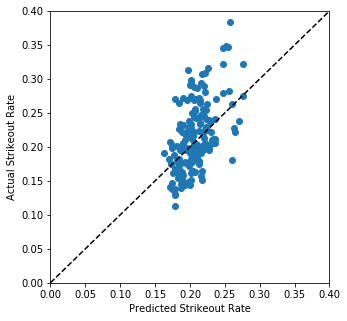

In [67]:
fig = plt.figure(figsize=(5,5))
plt.scatter(y_pred, y_test)
plt.plot([0., 0.4], [0., 0.4], 'k--')
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])
plt.xlabel('Predicted Strikeout Rate')
plt.ylabel('Actual Strikeout Rate')
plt.show()

#### Optimized AdaBoost

In [68]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 1000],
    'learning_rate': [0.1, 0.5, 1.0, 5.0, 10.0],
    'loss': ['linear', 'square', 'exponential']
}
# Create a based model
ab = AdaBoostRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ab, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Fitting 3 folds for each of 105 candidates, totalling 315 fits
[CV] learning_rate=0.1, loss=linear, n_estimators=10 .................
[CV] learning_rate=0.1, loss=linear, n_estimators=10 .................
[CV] learning_rate=0.1, loss=linear, n_estimators=10 .................
[CV] learning_rate=0.1, loss=linear, n_estimators=20 .................
[CV] .. learning_rate=0.1, loss=linear, n_estimators=10, total=   0.0s
[CV] .. learning_rate=0.1, loss=linear, n_estimators=10, total=   0.0s
[CV] .. learning_rate=0.1, loss=linear, n_estimators=10, total=   0.0s
[CV] learning_rate=0.1, loss=linear, n_estimators=20 .................
[CV] learning_rate=0.1, loss=linear, n_estimators=20 .................
[CV] learning_rate=0.1, loss=linear, n_estimators=50 .................
[CV] .. learning_rate=0.1, loss=linear, n_estimators=20, total=   0.1s
[CV] learning_rate=0.1, loss=linear, n_estimators=50 .................
[CV] .. learning_rate=0.1, loss=linear, n_estimators=20, total=   0.1s
[CV] learning_

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    7.2s


[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, total=   0.8s
[CV] learning_rate=0.1, loss=exponential, n_estimators=200 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, total=   1.1s
[CV] learning_rate=0.1, loss=exponential, n_estimators=300 ...........
[CV]  learning_rate=0.1, loss=square, n_estimators=1000, total=   4.3s
[CV] learning_rate=0.1, loss=square, n_estimators=1000 ...............
[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, total=   1.2s
[CV] learning_rate=0.1, loss=exponential, n_estimators=300 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=300, total=   1.6s
[CV] learning_rate=0.1, loss=exponential, n_estimators=300 ...........
[CV]  learning_rate=0.1, loss=square, n_estimators=1000, total=   4.8s
[CV] learning_rate=0.1, loss=exponential, n_estimators=1000 ..........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=300, total=   1.6s
[CV] learning_rate=0.1, loss=exponential, n_estimators=10

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.0s


[CV]  learning_rate=1.0, loss=exponential, n_estimators=50, total=   0.2s
[CV] learning_rate=1.0, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=1.0, loss=exponential, n_estimators=100, total=   0.5s
[CV] learning_rate=1.0, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=1.0, loss=exponential, n_estimators=100, total=   0.5s
[CV] learning_rate=1.0, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=1.0, loss=exponential, n_estimators=100, total=   0.5s
[CV] learning_rate=1.0, loss=exponential, n_estimators=200 ...........
[CV]  learning_rate=1.0, loss=exponential, n_estimators=200, total=   1.0s
[CV] learning_rate=1.0, loss=exponential, n_estimators=200 ...........
[CV]  learning_rate=1.0, loss=square, n_estimators=1000, total=   4.8s
[CV] learning_rate=1.0, loss=exponential, n_estimators=200 ...........
[CV]  learning_rate=1.0, loss=square, n_estimators=1000, total=   4.7s
[CV] learning_rate=1.0, loss=exponential, n_estimators=300

[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:  1.3min finished


{'learning_rate': 0.5, 'loss': 'square', 'n_estimators': 100}
Mean Absolute Error: 0.03419608926080286
Adjusted R^2: 0.19297236423868136


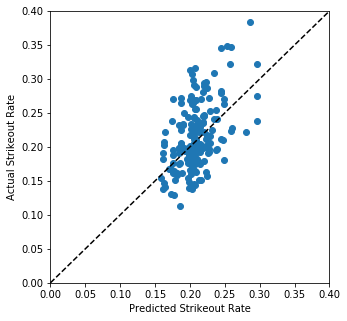

In [69]:
fig = plt.figure(figsize=(5,5))
plt.scatter(y_pred, y_test)
plt.plot([0., 0.4], [0., 0.4], 'k--')
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])
plt.xlabel('Predicted Strikeout Rate')
plt.ylabel('Actual Strikeout Rate')
plt.show()

#### Optimized XGBoost

In [70]:
param_grid = {"max_depth": (2, 5, 20),
              "learning_rate": (0.01, 0.1, 0.4),
              "min_child_weight": (1, 3, 5)}
# Create a based model
xgb = XGBRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

n = len(y_pred)
p = X_test.shape[1]

r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Adjusted R^2: {adj_r2}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] learning_rate=0.01, max_depth=2, min_child_weight=1 .............
[CV] learning_rate=0.01, max_depth=2, min_child_weight=1 .............
[CV] learning_rate=0.01, max_depth=2, min_child_weight=1 .............
[CV] learning_rate=0.01, max_depth=2, min_child_weight=3 .............
[CV]  learning_rate=0.01, max_depth=2, min_child_weight=1, total=   0.0s
[CV]  learning_rate=0.01, max_depth=2, min_child_weight=1, total=   0.0s
[CV]  learning_rate=0.01, max_depth=2, min_child_weight=1, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, min_child_weight=3 .............
[CV] learning_rate=0.01, max_depth=2, min_child_weight=3 .............
[CV] learning_rate=0.01, max_depth=2, min_child_weight=5 .............
[CV]  learning_rate=0.01, max_depth=2, min_child_weight=3, total=   0.1s
[CV] learning_rate=0.01, max_depth=2, min_child_weight=5 .............
[CV]  learning_rate=0.01, max_depth=2, min_child_weight=3, total=   0.0s
[CV] l

[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    1.5s finished


{'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 5}
Mean Absolute Error: 0.0341449183260407
Adjusted R^2: 0.19396885126387153


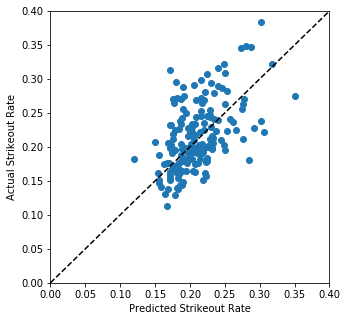

In [71]:
fig = plt.figure(figsize=(5,5))
plt.scatter(y_pred, y_test)
plt.plot([0., 0.4], [0., 0.4], 'k--')
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])
plt.xlabel('Predicted Strikeout Rate')
plt.ylabel('Actual Strikeout Rate')
plt.show()